## Imports

In [1]:
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.base import clone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skrebate import ReliefF
import joblib

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from itertools import product
import random
import ast

## Parameters

In [ ]:
SEED = 42
num_features = 4

# --- Carregar dataset Iris ---
def load_data_set():
    data = load_iris()
    X = data.data
    y = data.target
    return X, y

def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Modelo salvo em {filename}")

def load_model(filename):
    model = joblib.load(filename)
    print(f"Modelo carregado de {filename}")
    return model


X_iris, y_iris = load_data_set()

## Ex 1

In [3]:
#EX1
#EX1.1 ##################################
#EX1.1.1
#Usar critério 70/30 
def create_split_train_test(X, y, test_size=0.30, random_state=SEED):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    return X_train, X_test, y_train, y_test

#Usar critério 40/30/30
def create_split_tvt(X, y, val_size=0.30, test_size=0.30, random_state=SEED):
    # Primeiro separa o conjunto de teste
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Proporção relativa da validação dentro de X_temp (treino + validação)
    val_relative_size = val_size / (1.0 - test_size)

    # Depois separa treino e validação, estratificando por y_temp (não por y)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_relative_size, random_state=random_state, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

#EX1.1.2
def create_split_kfold(X, y, n_splits=5, random_state=None, shuffle=False):

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    folds = []

    for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        folds.append((fold, X_train, X_test, y_train, y_test))

    return folds

#EX 1.2 ##################################
#EX 1.2.1
def calcular_matriz_confusao(y_true, y_pred):
    #Retorna a matriz de confusão.
    return confusion_matrix(y_true, y_pred)

def mean_std_confusion_matrix(list_of_cms):
    arr = np.stack(list_of_cms, axis=0)  # shape (n_folds, n_classes, n_classes)
    mean_cm = np.mean(arr, axis=0)
    std_cm  = np.std(arr, axis=0, ddof=0)
    return mean_cm, std_cm

#EX1.2.2
def recall(y_true, y_pred, average='macro'):
    #Calcula o Recall.
    #O parâmetro 'average' pode ser: 'binary', 'micro', 'macro', 'weighted'.
    return recall_score(y_true, y_pred, average=average, zero_division=0)

#EX1.2.3
def precision(y_true, y_pred, average='macro'):
    #Calcula a Precision.
    return precision_score(y_true, y_pred, average=average, zero_division=0)

#EX1.2.4
def f1(y_true, y_pred, average='macro'):
    #Calcula o F1-score.
    return f1_score(y_true, y_pred, average=average, zero_division=0)

def metrics_to_dataframe(y_true, y_pred, label=""):
    """
    y_true e y_pred podem ser:
      - arrays únicos -> retorna métricas normais
      - listas de arrays (K-Fold) -> retorna médias e std
    """
    is_kfold = isinstance(y_true, list)

    if not is_kfold:
        # Caso normal
        cm = calcular_matriz_confusao(y_true, y_pred)
        recall_val = recall(y_true, y_pred)
        precision_val = precision(y_true, y_pred)
        f1_val = f1(y_true, y_pred)

        df = pd.DataFrame({
            "Label": [label],
            "Recall": [recall_val],
            "Precision": [precision_val],
            "F1-Score": [f1_val],
            "ConfusionMatrix": [cm]
        })
    else:
        recalls, precisions, f1s, cms = [], [], [], []
        for yt, yp in zip(y_true, y_pred):
            recalls.append(recall(yt, yp))
            precisions.append(precision(yt, yp))
            f1s.append(f1(yt, yp))
            cms.append(calcular_matriz_confusao(yt, yp))

        cms_mean, cms_std = mean_std_confusion_matrix(cms)

        df = pd.DataFrame({
            "Label": [label],
            "Recall_Mean": [np.mean(recalls)],
            "Recall_Std": [np.std(recalls)],
            "Precision_Mean": [np.mean(precisions)],
            "Precision_Std": [np.std(precisions)],
            "F1_Mean": [np.mean(f1s)],
            "F1_Std": [np.std(f1s)],
            "ConfusionMatrices_mean": [cms_mean],
            "ConfusionMatrices_std": [cms_std]
        })

    return df

def print_metrics(y_true, y_pred, label="Metric Results", printing = True):
    """
    y_true e y_pred podem ser:
      - arrays únicos
      - listas de arrays (K-Fold)
    """
    is_kfold = isinstance(y_true, list)

    if not is_kfold:
        cm = calcular_matriz_confusao(y_true, y_pred)
        rec = recall(y_true, y_pred)
        prec = precision(y_true, y_pred)
        f1s = f1(y_true, y_pred)

        if printing:
            print(f"\n===== {label} =====")
            print("Confusion Matrix:")
            print(cm)
            print(f"Recall:    {rec:.4f}")
            print(f"Precision: {prec:.4f}")
            print(f"F1-Score:  {f1s:.4f}")
            print("=========================")

        return {"confusion_matrix": cm, "recall": rec, "precision": prec, "f1-score": f1s}

    else:
        recalls, precisions, f1s, cms = [], [], [], []
        for yt, yp in zip(y_true, y_pred):
            recalls.append(recall(yt, yp))
            precisions.append(precision(yt, yp))
            f1s.append(f1(yt, yp))
            cms.append(calcular_matriz_confusao(yt, yp))

        if printing:
            print(f"\n===== {label} - K-Fold results =====")
            print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
            print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
            print(f"F1-Score:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
            print("(Confusion matrices individuais guardadas no array.)")
            print("=========================")

        return {"confusion_matrices": cms, 
                "recall_mean": np.mean(recalls), "recall_std": np.std(recalls),
                "precision_mean": np.mean(precisions), "precision_std": np.std(precisions),
                "f1_mean": np.mean(f1s), "f1_std": np.std(f1s)}


## EX 2.1

In [4]:
# Função para o classificador Random
def classifier_random(X_train, y_train, X_test, y_test, label ="", printing = True):
    clf = DummyClassifier(strategy='uniform', random_state=SEED)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # metrics_df = metrics_to_dataframe(y_test, y_pred, label)
    metrics = print_metrics(y_test, y_pred, label=label, printing=printing)

    return metrics, y_pred

#Função para o classificador OneR
def classifier_oneR(X_train, y_train, X_test, y_test, max_depth=1, label = "", printing=True):
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=SEED)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # metrics_df = metrics_to_dataframe(y_test, y_pred, label)
    metrics = print_metrics(y_test, y_pred, label=label, printing=printing)

    return metrics, y_pred

#Função para o classificador kNN
def classifier_kNN(X_train, y_train, X_test, y_test, k, label = "", printing=True, filename=None):
    clf = KNeighborsClassifier(k)
    clf.fit(X_train, y_train)
    if X_test is not None:
        y_pred = clf.predict(X_test)

        # metrics_df = metrics_to_dataframe(y_test, y_pred, label)
        metrics = print_metrics(y_test, y_pred, label=label, printing=printing)
        return metrics, y_pred
    else:
        save_model(clf, filename)

    

###########################################
################ MODELOS ##################
###########################################

def evaluate_with_kfold(X, y, classifier, rkf, label="KFOLD", printing=True):
    y_preds, y_trues = [], []

    for train_idx, test_idx in rkf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = clone(classifier)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        y_trues.append(y_test)
        y_preds.append(y_pred)

    # metrics_df = metrics_to_dataframe(y_trues, y_preds, label=label)
    metrics = print_metrics(y_trues, y_preds, label=label, printing=printing)
    return metrics

def random_baseline_kfold(X, y, rkf):
    clf = DummyClassifier(strategy='uniform', random_state=SEED)
    return evaluate_with_kfold(X, y, clf, rkf, label="RANDOM Baseline - KFOLD")

def oneR_baseline_kfold(X, y, rkf):
    clf = DecisionTreeClassifier(max_depth=1, random_state=SEED)
    return evaluate_with_kfold(X, y, clf, rkf, label="ONE R Baseline - KFOLD")

def random_baseline(X, y):
    # TRAIN ONLY:
    metrics_to, _ = classifier_random(X, y, X, y, label="RANDOM Baseline - TRAIN ONLY")

    # Train, test sets:
    X_train_70, X_test_70, y_train_30, y_test_30 = create_split_train_test(X, y, test_size=0.3, random_state=SEED)
    metrics_tt, _ = classifier_random(X_train_70, y_train_30, X_test_70, y_test_30, label="RANDOM Baseline - Train Test")

    rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=SEED)
    metrics_cv = random_baseline_kfold(X, y, rkf)

    return metrics_to, metrics_tt, metrics_cv

def oneR_baseline(X, y):
        # TRAIN ONLY:
    metrics_to, _ = classifier_oneR(X, y, X, y, label="ONE R TRAIN ONLY")

    # Train, test sets:
    X_train_70, X_test_70, y_train_30, y_test_30 = create_split_train_test(X, y, test_size=0.3, random_state=SEED)
    metrics_tt, _ = classifier_oneR(X_train_70, y_train_30, X_test_70, y_test_30, label="ONE R Train Test")

    rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=SEED)
    metrics_cv = oneR_baseline_kfold(X, y, rkf)

    return metrics_to, metrics_tt, metrics_cv

def ex_2_1(X, y):

    # RANDOM BASELINE
    ran_to, ran_tt, ran_cv = random_baseline(X, y)

    # ONER BASELIDE
    one_to, one_tt, one_cv = oneR_baseline(X, y)

    return

ex_2_1(X_iris, y_iris)


===== RANDOM Baseline - TRAIN ONLY =====
Confusion Matrix:
[[15 15 20]
 [18 21 11]
 [15 10 25]]
Recall:    0.4067
Precision: 0.4052
F1-Score:  0.4051

===== RANDOM Baseline - Train Test =====
Confusion Matrix:
[[2 6 7]
 [6 4 5]
 [6 2 7]]
Recall:    0.2889
Precision: 0.2815
F1-Score:  0.2820

===== RANDOM Baseline - KFOLD - K-Fold results =====
Recall:    0.4000 ± 0.0000
Precision: 0.4444 ± 0.0000
F1-Score:  0.3862 ± 0.0000
(Confusion matrices individuais guardadas no array.)

===== ONE R TRAIN ONLY =====
Confusion Matrix:
[[50  0  0]
 [ 0 50  0]
 [ 0 50  0]]
Recall:    0.6667
Precision: 0.5000
F1-Score:  0.5556

===== ONE R Train Test =====
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0 15  0]]
Recall:    0.6667
Precision: 0.5000
F1-Score:  0.5556

===== ONE R Baseline - KFOLD - K-Fold results =====
Recall:    0.6667 ± 0.0000
Precision: 0.5000 ± 0.0000
F1-Score:  0.5556 ± 0.0000
(Confusion matrices individuais guardadas no array.)


## EX 2.2.1

In [5]:


## EX2.2.1 ################################
def ex_2_2_1(X_iris, y_iris):

    k = 1
    clf_k = KNeighborsClassifier(n_neighbors = k)

    # TO
    clf_k.fit(X_iris, y_iris)
    y_pre_trainonly = clf_k.predict(X_iris)
    print_metrics(y_iris, y_pre_trainonly, "KNN FOR TRAIN ONLY")

    # TT 70-30
    X_train_70, X_test_30, y_train_70, y_test_30 = create_split_train_test(X_iris, y_iris, test_size=0.3, random_state=SEED)
    clf_k.fit(X_train_70, y_train_70)
    y_pre_tt_70_30 = clf_k.predict(X_test_30)
    print_metrics(y_test_30, y_pre_tt_70_30, "KNN FOR TRAIN TEST 70-30")

    # KFolds
    rkf = RepeatedStratifiedKFold(n_splits = 10, n_repeats=10, random_state=SEED)
    clf_for_kfolds = KNeighborsClassifier(n_neighbors=k)
    evaluate_with_kfold(X_iris, y_iris, clf_for_kfolds, rkf, label="KNN KFOLDS")

    # print_metrics(cms, precisions, recalls, f1s)

ex_2_2_1(X_iris, y_iris)


===== KNN FOR TRAIN ONLY =====
Confusion Matrix:
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
Recall:    1.0000
Precision: 1.0000
F1-Score:  1.0000

===== KNN FOR TRAIN TEST 70-30 =====
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  3 12]]
Recall:    0.9333
Precision: 0.9444
F1-Score:  0.9327

===== KNN KFOLDS - K-Fold results =====
Recall:    0.9587 ± 0.0469
Precision: 0.9646 ± 0.0416
F1-Score:  0.9581 ± 0.0476
(Confusion matrices individuais guardadas no array.)


## EX 2.2.2

======================================== TO - Different k nearest
======================================== TVT - Different k nearest
======================================== 10x10CV - Different k nearest


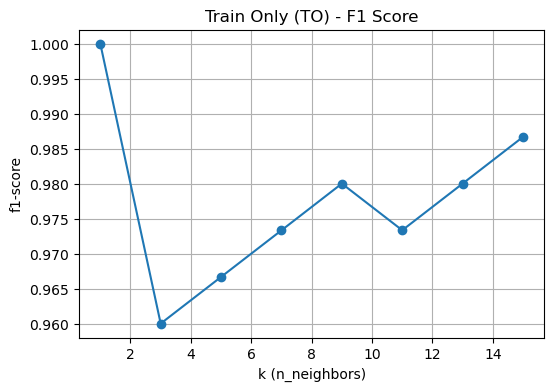

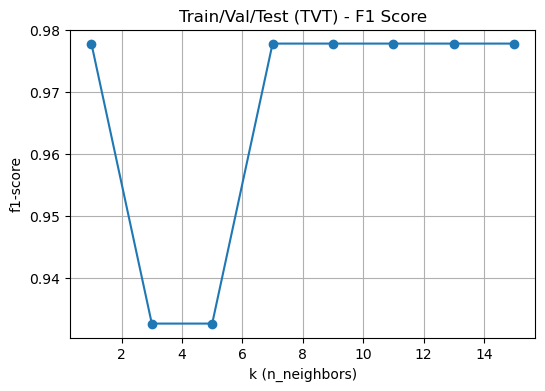

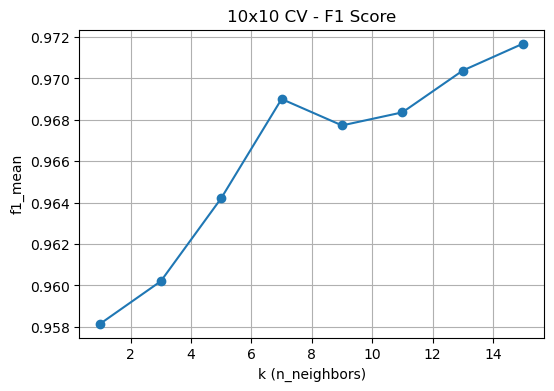

In [6]:
## EX2.2.2 ################################

PRINTING = False

def plot_metrics(metrics_list, metric_name='f1-score', title='Metric Plot'):
    ks = [m['k'] for m in metrics_list]
    values = [m[metric_name] for m in metrics_list]

    plt.figure(figsize=(6,4))
    plt.plot(ks, values, marker='o')
    plt.xlabel("k (n_neighbors)")
    plt.ylabel(metric_name)
    plt.title(title)
    plt.grid(True)
    plt.show()

# ⚠️ Pôr a guardar em CSV
def ex_2_to(X_iris, y_iris, min_range=1, max_range=15, step=2, printing = True):
    metrics_list = []

    for k in range(min_range, max_range + 1, step):
        clf_k = KNeighborsClassifier(n_neighbors=k)
        clf_k.fit(X_iris, y_iris)
        y_pred = clf_k.predict(X_iris)
        metrics = print_metrics(y_iris, y_pred, f"Train only - k={k}", printing=printing)
        metrics['k'] = k
        metrics_list.append(metrics)

    return metrics_list

def ex_2_tvt(X_iris, y_iris, min_range = 1, max_range = 15, step = 2, printing=True):
    metrics_list = []

    for i in range(min_range, max_range + 1, step):
        k = i
        clf_k = KNeighborsClassifier(n_neighbors = k)

        X_train_40, X_temp, y_train_40, y_temp = create_split_train_test(X_iris, y_iris, test_size=0.6, random_state=SEED)
        X_test_30, X_val_30, y_test_30, y_val_30 = create_split_train_test(X_temp, y_temp, test_size=0.5, random_state=SEED)
        
        clf_k.fit(X_train_40, y_train_40)
        y_pre_tt_40_30_30 = clf_k.predict(X_val_30)

        metrics = print_metrics(y_val_30, y_pre_tt_40_30_30, f"TT 40-30-30 - {k}", printing=printing)
        metrics['k'] = k
        metrics_list.append(metrics)
    
    return metrics_list

def ex_2_cv(X_iris, y_iris, min_range = 1, max_range = 15, step = 2, printing=True):
    metrics_list = []

    for i in range(min_range, max_range + 1, step):
        k = i
        rkf = RepeatedStratifiedKFold(n_splits = 10, n_repeats=10, random_state=SEED)

        clf_for_kfolds = KNeighborsClassifier(n_neighbors=k)
        metrics = evaluate_with_kfold(X_iris, y_iris, clf_for_kfolds, rkf, label="KNN KFOLDS", printing=printing)

        metrics['k'] = k
        metrics_list.append(metrics)

    return metrics_list

def ex_2_2_2(X_iris, y_iris, min_range = 1, max_range = 15, step = 2, printing=True):
    print("=" * 40, "TO - Different k nearest")
    to_metrics = ex_2_to(X_iris, y_iris, min_range = min_range, max_range = max_range, step = step, printing=PRINTING)

    print("=" * 40, "TVT - Different k nearest")
    tvt_metrics = ex_2_tvt(X_iris, y_iris, min_range = min_range, max_range = max_range, step = step, printing=PRINTING)

    print("=" * 40, "10x10CV - Different k nearest")
    cv_metrics = ex_2_cv(X_iris, y_iris, min_range = min_range, max_range = max_range, step = step, printing=PRINTING)

    plot_metrics(to_metrics, metric_name='f1-score', title='Train Only (TO) - F1 Score')
    plot_metrics(tvt_metrics, metric_name='f1-score', title='Train/Val/Test (TVT) - F1 Score')
    plot_metrics(cv_metrics, metric_name='f1_mean', title='10x10 CV - F1 Score')

    return to_metrics, tvt_metrics, cv_metrics

to_metrics, tvt_metrics, cv_metrics = ex_2_2_2(X_iris, y_iris)

### Values in Tables

In [7]:
def metrics_summary_all(to_metrics, tvt_metrics, cv_metrics, min_k=1, max_k=15, step=2):
    """
    Retorna 3 DataFrames, um para cada tipo de experimento (TO, TVT, CV),
    com colunas: k, recall, precision, f1
    """
    ks = list(range(min_k, max_k+1, step))
    
    def summary_df(metrics_list, ks):
        recall_vals, precision_vals, f1_vals = [], [], []
        for m in metrics_list:
            if 'recall' in m:
                recall_vals.append(m['recall'])
                precision_vals.append(m['precision'])
                f1_vals.append(m['f1-score'])
            else:
                recall_vals.append(m['recall_mean'])
                precision_vals.append(m['precision_mean'])
                f1_vals.append(m['f1_mean'])
        return pd.DataFrame({
            'k': ks,
            'recall': recall_vals,
            'precision': precision_vals,
            'f1': f1_vals
        })
    
    df_to = summary_df(to_metrics, ks)
    df_tvt = summary_df(tvt_metrics, ks)
    df_cv = summary_df(cv_metrics, ks)
    
    return df_to, df_tvt, df_cv

# Uso:
df_to, df_tvt, df_cv = metrics_summary_all(to_metrics, tvt_metrics, cv_metrics, min_k=1, max_k=15, step=2)

print("=== Train Only (TO) ===")
display(df_to)

print("=== Train/Val/Test (TVT) ===")
display(df_tvt)

print("=== 10x10 CV ===")
display(df_cv)


=== Train Only (TO) ===


,k,recall,precision,f1
0,1,1.000000,1.000000,1.000000
1,3,0.960000,0.960000,0.960000
2,5,0.966667,0.966787,0.966663
3,7,0.973333,0.973825,0.973323
4,9,0.980000,0.980125,0.979998
5,11,0.973333,0.973333,0.973333
6,13,0.980000,0.980125,0.979998
7,15,0.986667,0.986667,0.986667


=== Train/Val/Test (TVT) ===


,k,recall,precision,f1
0,1,0.977778,0.979167,0.977753
1,3,0.933333,0.944444,0.932660
2,5,0.933333,0.944444,0.932660
3,7,0.977778,0.979167,0.977753
4,9,0.977778,0.979167,0.977753
5,11,0.977778,0.979167,0.977753
6,13,0.977778,0.979167,0.977753
7,15,0.977778,0.979167,0.977753


=== 10x10 CV ===


,k,recall,precision,f1
0,1,0.958667,0.964571,0.958146
1,3,0.960667,0.966302,0.960195
2,5,0.964667,0.970079,0.964209
3,7,0.969333,0.973651,0.969007
4,9,0.968000,0.971937,0.967729
5,11,0.968667,0.972651,0.968360
6,13,0.970667,0.974825,0.970382
7,15,0.972000,0.976095,0.971687


## EX 2.3.1 - TVT
### Best features

Score:
[3 2 0 1]

===== KNN - k = 1 - feature ranking: [3] =====
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  2 13]]
Recall:    0.9556
Precision: 0.9608
F1-Score:  0.9554

===== KNN - k = 1 - feature ranking: [3 2] =====
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]
Recall:    0.9778
Precision: 0.9792
F1-Score:  0.9778

===== KNN - k = 1 - feature ranking: [3 2 0] =====
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]
Recall:    0.9778
Precision: 0.9792
F1-Score:  0.9778

===== KNN - k = 1 - feature ranking: [3 2 0 1] =====
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1 14]]
Recall:    0.9778
Precision: 0.9792
F1-Score:  0.9778


,n_features,recall,precision,f1
0,1,0.955556,0.960784,0.955357
1,2,0.977778,0.979167,0.977753
2,3,0.977778,0.979167,0.977753
3,4,0.977778,0.979167,0.977753


TOP 2 features
BEST FEATURES [3 2]


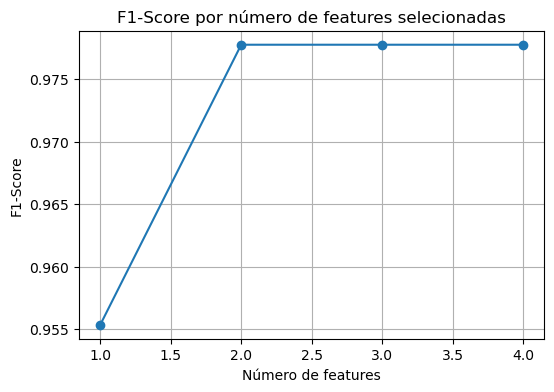

In [8]:
def metrics_summary_features(metrics_list):
    n_features = [m['n_features'] for m in metrics_list]
    recall = []
    precision = []
    f1 = []

    for m in metrics_list:
        recall.append(m['recall'])
        precision.append(m['precision'])
        f1.append(m['f1-score'])

    return pd.DataFrame({
        'n_features': n_features,
        'recall': recall,
        'precision': precision,
        'f1': f1
    })

def compute_feature_ranking(X, y):
    relief = ReliefF(n_neighbors=20)
    relief.fit(X, y)
    scores = relief.feature_importances_

    return np.argsort(scores)[::-1]     # ordem decrescente

def bestFeatures(X_train, y_train, X_val, y_val, plot = True):
    scores = compute_feature_ranking(X_train, y_train)
    print("Score:")
    print(scores)

    k_base = 1

    metrics_list = []

    for i in range(len(scores)):
        X_train_i = X_train[:, scores[:i+1]]
        X_val_i = X_val[:, scores[:i+1]]
        # def classifier_kNN(X_train, y_train, X_test, y_test, k, label = "", printing=True):
        metrics, _ = classifier_kNN(X_train_i, y_train, X_val_i, y_val, k_base, f"KNN - k = 1 - feature ranking: {scores[:i+1]}", printing=True)
        
        metrics['n_features'] = i+1
        metrics_list.append(metrics)
    
    df_feat = metrics_summary_features(metrics_list)
    display(df_feat)

    best_idx = df_feat['f1'].idxmax()
    best_n = df_feat.loc[best_idx, 'n_features']
    best_features = scores[:best_n]

    print(f"TOP {len(best_features)} features")
    print("BEST FEATURES", best_features)

    if plot:
        # Plot do F1
        plt.figure(figsize=(6,4))
        plt.plot(df_feat['n_features'], df_feat['f1'], marker='o')
        plt.xlabel("Número de features")
        plt.ylabel("F1-Score")
        plt.title("F1-Score por número de features selecionadas")
        plt.grid(True)
        plt.show()
    
    return best_features


X_train, X_val, X_test, y_train, y_val, y_test = create_split_tvt(X_iris, y_iris)

best_features = bestFeatures(X_train, y_train, X_val, y_val)

### Best k

In [9]:
def best_k_tvt(X_train, y_train, X_val, y_val, min_range=1, max_range=15, step=2, printing = True):
    f1_list = []

    for k in range(min_range, max_range + 1, step):
        tuple = classifier_kNN(X_train, y_train, X_val, y_val, k, f"KNN - best K : {k}", printing=False)
        f1 = {'f1-score': tuple[0]['f1-score']}
        f1['k'] = k
        f1_list.append(f1)

    return f1_list

def best_parameter_values(X_train, y_train, X_val, y_val, best_features, min_range = 1, max_range = 15, step = 2):
    X_train = X_train[:, best_features]
    X_val = X_val[:, best_features]
    
    f1_list = best_k_tvt(X_train, y_train, X_val, y_val)

    df = pd.DataFrame(f1_list)
    display(df)

    # k com maior f1-score
    best_idx = df['f1-score'].idxmax()
    best_k = df.loc[best_idx, 'k']
    
    print(f"Melhor k com maior F1-score: {best_k}")
    return best_k

best_k = best_parameter_values(X_train, y_train, X_val, y_val, best_features)

,f1-score,k
0,0.977753,1
1,0.977753,3
2,0.977753,5
3,0.977753,7
4,0.977753,9
5,0.977753,11
6,0.977753,13
7,0.977753,15


Melhor k com maior F1-score: 1


### Train with Tr+V -> Get T

"Estimation of exa..."
1.4

In [10]:

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

metrics, _ = classifier_kNN(X_train_val, y_train_val, X_test, y_test, best_k, f"KNN - features: {best_features} - k={best_k}", printing=True)



===== KNN - features: [3 2] - k=1 =====
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  3 12]]
Recall:    0.9333
Precision: 0.9444
F1-Score:  0.9327


### Deployment

In [11]:
filename = "./models/ex_2_3_1_knn_tvt.pkl"
label = f"KNN Deploy | features: {best_features} - k={best_k}"

classifier_kNN(X_iris, y_iris, None, None, best_k, label=label, filename = filename)

Modelo salvo em ./models/ex_2_3_1_knn_tvt.pkl


## EX 2.3.1 - CV

In [ ]:
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=SEED)
print(rkf.split(X_iris, y_iris))

def classifier_model(model, X_train, y_train, X_test, y_test, label = "", printing=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # metrics_df = metrics_to_dataframe(y_test, y_pred, label)
    metrics = print_metrics(y_test, y_pred, label=label, printing=printing)

    return metrics, y_pred

def bestFeatures_2(X_train, y_train, X_val, y_val, classifier, plot = True, printing=True):
    scores = compute_feature_ranking(X_train, y_train)
    if printing:
        print("Score:")
        print(scores)

    k_base = 1

    metrics_list = []

    for i in range(len(scores)):
        X_train_i = X_train[:, scores[:i+1]]
        X_val_i = X_val[:, scores[:i+1]]

        metrics, _ = classifier_model(classifier, X_train_i, y_train, X_val_i, y_val, "", False)

        metrics['n_features'] = i+1
        metrics_list.append(metrics)
    
    df_feat = metrics_summary_features(metrics_list)
    # display(df_feat)

    best_idx = df_feat['f1'].idxmax()
    best_n = df_feat.loc[best_idx, 'n_features']
    best_features = scores[:best_n]

    if printing:
        print(f"TOP {len(best_features)} features")
        print("BEST FEATURES", best_features)

    if plot:
        # Plot do F1
        plt.figure(figsize=(6,4))
        plt.plot(df_feat['n_features'], df_feat['f1'], marker='o')
        plt.xlabel("Número de features")
        plt.ylabel("F1-Score")
        plt.title("F1-Score por número de features selecionadas")
        plt.grid(True)
        plt.show()
    
    return best_features


def get_parameters(modelName):

    knn_parameters = {
        'n_neighbors': [1, 3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    decisionTree_parameters = {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }

    SVM_parameters = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }

    ANN_parameters = {
        'hidden_layer_sizes': [(50,), (100,), (50,50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01]
    }

    if modelName == "kNN":
        return knn_parameters
    elif modelName == "C4.5":
        return decisionTree_parameters
    elif modelName == "SVM":
        return SVM_parameters
    elif modelName == "ANN":
        return ANN_parameters
    else:
        raise ValueError(f"Modelo {modelName} não reconhecido.")
        
def testar_modelo_manual(model, param_grid, X_train, y_train, X_val, y_val):
    """
    Itera sobre todas as combinações de parâmetros e devolve o melhor com F1-score.
    """
    keys = list(param_grid.keys())
    valores = list(param_grid.values())
    best_score = -1
    best_params = None

    # Itera todas as combinações
    for comb in product(*valores):
        params = dict(zip(keys, comb))
        model.set_params(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, average='macro')  # macro ou weighted

        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score

def escolher_modelos_por_fold(f1_csv, params_csv, bff_csv):
    df_f1 = pd.read_csv(f1_csv)
    df_params = pd.read_csv(params_csv)
    df_bff = pd.read_csv(bff_csv)

    model_names = [col for col in df_f1.columns if col != "Fold"]

    vencedores = []

    for idx, row in df_f1.iterrows():
        fold = row["Fold"]

        # F1 deste fold
        f1_scores = row[model_names]
        max_f1 = f1_scores.max()

        # modelos empatados
        empatados = [m for m in model_names if f1_scores[m] == max_f1]

        # escolha aleatória
        modelo_escolhido = random.choice(empatados)

        # parâmetros do modelo vencedor
        params_str = df_params.loc[df_params["Fold"] == fold, modelo_escolhido].values[0]
        params = ast.literal_eval(params_str)

        # Best feature set
        bff_str = df_bff.loc[df_bff["Fold"] == fold, modelo_escolhido].values[0]

        # corrigir caso esteja no formato "[3 2 0]"
        bff_corrigido = (
            bff_str.replace("[", "")
                   .replace("]", "")
                   .replace("  ", " ")
                   .strip()
        )

        # inserir vírgulas
        bff_corrigido = "[" + ",".join(bff_corrigido.split()) + "]"

        best_features = ast.literal_eval(bff_corrigido)

        vencedores.append({
            "Fold": fold,
            "Model": modelo_escolhido,
            "Params": params,
            "Best_Feature_Set": best_features
        })

    return vencedores

def create_model(model_name, params):
    if model_name == "kNN":
        return KNeighborsClassifier(**params)
    elif model_name == "C4.5":
        return DecisionTreeClassifier(random_state=SEED, **params)
    elif model_name == "SVM":
        return SVC(random_state=SEED, **params)
    elif model_name == "ANN":
        return MLPClassifier(random_state=SEED, max_iter=1000, **params)
    else:
        raise ValueError("Modelo desconhecido: " + model_name)
    
def treinar_e_testar(folds, vencedores):
    resultados_test = []

    for fold_data, vencedor in zip(folds, vencedores):
        model_name = vencedor["Model"]
        params = vencedor["Params"]
        feature_set = vencedor["Best_Feature_Set"]

        print(f"\n=== FOLD {vencedor['Fold']} | Modelo escolhido: {model_name} ===")

        # 1. Criar modelo com os melhores parâmetros
        model = create_model(model_name, params)

        # 2. Treinar com o treino completo (train_orig)
        X_tr = fold_data["X_train_orig"]
        y_tr = fold_data["y_train_orig"]

        # 3. Treinar o modelo
        model.fit(X_tr, y_tr)

        # 4. Avaliar no Test (Re)
        X_test = fold_data["X_test"]
        y_test = fold_data["y_test"]

        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")

        resultados_test.append({
            "Fold": vencedor["Fold"],
            "Model": model_name,
            "Params": params,
            "Feature Set": feature_set,
            "Test_F1": f1
        })

        print(f"F1 no Test: {f1}")

    return pd.DataFrame(resultados_test)

def analisar_f1(f1_csv):
    df = pd.read_csv(f1_csv)

    if not {"Model", "Test_F1"}.issubset(df.columns):
        raise ValueError("O CSV deve ter colunas 'Model' e 'Test_F1'.")

    # Agrupar por modelo
    stats = df.groupby("Model")["Test_F1"].agg(["mean", "std"]).reset_index()

    print("=== Estatísticas por modelo ===")
    for _, row in stats.iterrows():
        print(f"{row['Model']}: média = {row['mean']:.4f}, std = {row['std']:.4f}")

    # Modelo com maior média
    melhor_modelo = stats.loc[stats["mean"].idxmax()]
    print("\n=== Melhor modelo ===")
    print(f"Modelo: {melhor_modelo['Model']} (média = {melhor_modelo['mean']:.4f})")

    return stats, melhor_modelo

def ex_2_3_1_cv(X, y):

    folds = []
    fold_feature_ranking = []

    for train_idx, test_idx in rkf.split(X, y):
        # train (90%) + test (10%)
        X_train_orig, X_test = X[train_idx], X[test_idx]
        y_train_orig, y_test = y[train_idx], y[test_idx]

        # train (90% * 0.9) + validation (90% * 0.1)
        # 80 + 10 + 10
        X_train, X_val, y_train, y_val = create_split_train_test(X_train_orig, y_train_orig, test_size=0.1)

        dic = {"X_train_orig": X_train_orig, 
            "y_train_orig": y_train_orig,
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
            "X_val": X_val,
            "y_val": y_val}
        
        folds.append(dic)
    
    models = {
        "kNN": KNeighborsClassifier(),                           # k=5 por defeito
        "C4.5": DecisionTreeClassifier(random_state=SEED),       # Decision Tree
        "SVM": SVC(random_state=SEED),                           # SVM com kernel RBF por omissão
        "ANN": MLPClassifier(random_state=SEED, max_iter=1000)   # Rede Neural
    }

    # f1_fold_list = []
    # best_params_list = []
    # bff_list = []
    

    # f = 0
    # for fold in folds:
    #     print(f"FOLD {f}:")
    #     f += 1

    #     f1_model_list = []
    #     params_model_list = []
    #     bff_model_list = []

    #     for modelName, model in models.items():
    #         bff = bestFeatures_2(fold["X_train"], fold["y_train"], fold["X_val"], fold["y_val"], model, plot=False, printing=False)
    #         param_grid = get_parameters(modelName)
    #         melhores_params, melhor_f1 = testar_modelo_manual(model, param_grid, fold["X_train"][:, bff], fold["y_train"], fold["X_val"][:, bff], fold["y_val"])

    #         f1_model_list.append(melhor_f1)
    #         params_model_list.append(melhores_params)
    #         bff_model_list.append(bff)
        
    #     f1_fold_list.append(f1_model_list)
    #     best_params_list.append(params_model_list)
    #     bff_list.append(bff_model_list)

    # CSV
    # df_f1 = pd.DataFrame(
    #     f1_fold_list,                     # dados
    #     columns=list(models.keys())       # nomes dos modelos como colunas
    # )

    # df_params = pd.DataFrame(
    #     best_params_list,
    #     columns=list(models.keys())
    # )

    # df_bff = pd.DataFrame(
    #     bff_list,
    #     columns=list(models.keys())
    # )

    # # Adicionar coluna do número da fold
    # df_f1.insert(0, 'Fold', range(len(f1_fold_list)))
    # df_params.insert(0, 'Fold', range(len(best_params_list)))
    # df_bff.insert(0, 'Fold', range(len(bff_list)))

    # # Mostrar DataFrame
    # display(df_f1)
    # df_f1.to_csv("./graphics/Models_f1_scores_per_fold_tr_v.csv", index=False)
    # df_params.to_csv("./graphics/Models_best_params_per_fold_tr_v.csv", index=False)
    # df_bff.to_csv("./graphics/Models_bff_per_fold_tr_v.csv", index=False)

    # ESCOLHER MELHOR MODELO
    vencedores = escolher_modelos_por_fold(
        "./graphics/Models_f1_scores_per_fold_tr_v.csv",
        "./graphics/Models_best_params_per_fold_tr_v.csv",
        "./graphics/Models_bff_per_fold_tr_v.csv"
    )

    df_test_scores = treinar_e_testar(folds, vencedores)

    display(df_test_scores)

    df_test_scores.to_csv("./graphics/Test_results.csv", index=False)

    analisar_f1("./graphics/Test_results.csv")




<generator object _RepeatedSplits.split at 0x000001C945AD76E0>


In [21]:
ex_2_3_1_cv(X_iris, y_iris)


=== FOLD 0.0 | Modelo escolhido: kNN ===
F1 no Test: 1.0

=== FOLD 1.0 | Modelo escolhido: kNN ===
F1 no Test: 1.0

=== FOLD 2.0 | Modelo escolhido: ANN ===
F1 no Test: 0.9326599326599326

=== FOLD 3.0 | Modelo escolhido: ANN ===
F1 no Test: 1.0

=== FOLD 4.0 | Modelo escolhido: kNN ===
F1 no Test: 0.8666666666666667

=== FOLD 5.0 | Modelo escolhido: kNN ===
F1 no Test: 0.8611111111111112

=== FOLD 6.0 | Modelo escolhido: C4.5 ===
F1 no Test: 1.0

=== FOLD 7.0 | Modelo escolhido: kNN ===
F1 no Test: 1.0

=== FOLD 8.0 | Modelo escolhido: kNN ===
F1 no Test: 1.0

=== FOLD 9.0 | Modelo escolhido: ANN ===
F1 no Test: 1.0

=== FOLD 10.0 | Modelo escolhido: kNN ===
F1 no Test: 0.9326599326599326

=== FOLD 11.0 | Modelo escolhido: SVM ===
F1 no Test: 0.9326599326599326

=== FOLD 12.0 | Modelo escolhido: SVM ===
F1 no Test: 1.0

=== FOLD 13.0 | Modelo escolhido: ANN ===
F1 no Test: 1.0

=== FOLD 14.0 | Modelo escolhido: C4.5 ===
F1 no Test: 0.8666666666666667

=== FOLD 15.0 | Modelo escolhido

,Fold,Model,Params,Feature Set,Test_F1
0,0.0,kNN,"{'n_neighbors': 5, 'weights': 'uniform', 'metr...",[3],1.000000
1,1.0,kNN,"{'n_neighbors': 3, 'weights': 'uniform', 'metr...",[3],1.000000
2,2.0,ANN,"{'hidden_layer_sizes': (50,), 'activation': 'r...","[3, 2, 0]",0.932660
3,3.0,ANN,"{'hidden_layer_sizes': (50,), 'activation': 'r...","[3, 2, 0]",1.000000
4,4.0,kNN,"{'n_neighbors': 1, 'weights': 'uniform', 'metr...",[3],0.866667
...,...,...,...,...,...
95,95.0,kNN,"{'n_neighbors': 1, 'weights': 'uniform', 'metr...","[3, 2, 0]",0.866667
96,96.0,ANN,"{'hidden_layer_sizes': (50,), 'activation': 'r...","[3, 2, 0]",1.000000
97,97.0,kNN,"{'n_neighbors': 3, 'weights': 'uniform', 'metr...",[3],1.000000
98,98.0,ANN,"{'hidden_layer_sizes': (50,), 'activation': 'r...",[3],1.000000


=== Estatísticas por modelo ===
ANN: média = 0.9663, std = 0.0437
C4.5: média = 0.9475, std = 0.0657
SVM: média = 0.9796, std = 0.0374
kNN: média = 0.9572, std = 0.0518

=== Melhor modelo ===
Modelo: SVM (média = 0.9796)
